<a href="https://www.kaggle.com/code/edrickkesuma/yeo-johnson-optuna-kfold-cv-xgbregressor?scriptVersionId=91095998" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## TPS August 2021

This notebook is mostly based on the following notebook for Optuna tuning and KFold CV.
https://www.kaggle.com/michael127001/xgbregressor-with-optuna-tuning/notebook

The idea to use yeo-johnson transformation came from this discussion.
https://www.kaggle.com/c/tabular-playground-series-aug-2021/discussion/266321

I'm very new at dealing with high dimensional features, so please don't hesitate to give some input :)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import optuna

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2021/train.csv
/kaggle/input/tabular-playground-series-aug-2021/test.csv


In [2]:
# Read in the train and test data while making id the index
train_data = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv', index_col=['id'])
test_data = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv', index_col=['id'])
train_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
id,,,,,,,,,,,,,,,,,,,,,
0,-0.002350,59,0.766739,-1.350460,42.27270,16.68570,30.35990,1.267300,0.392007,1.09101,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.296580,10.489800,15
1,0.784462,145,-0.463845,-0.530421,27324.90000,3.47545,160.49800,0.828007,3.735860,1.28138,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.364700,1.143830,3
2,0.317816,19,-0.432571,-0.382644,1383.26000,19.71290,31.10260,-0.515354,34.430800,1.24210,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.696790,12.305500,6
3,0.210753,17,-0.616454,0.946362,-119.25300,4.08235,185.25700,1.383310,-47.521400,1.09130,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.456450,10.028800,2
4,0.439671,20,0.968126,-0.092546,74.30200,12.30650,72.18600,-0.233964,24.399100,1.10151,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.784850,7.071970,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.923980,6,0.663212,-0.055120,6.61768,1.26619,40.44790,0.852375,25.522400,1.12294,...,3517.97000,18.534200,1.41936,0.607504,4.950780,2.853420,0.961882,1.068010,1.437650,11
249996,0.243556,7,-0.557062,1.333470,-54.88610,17.58310,212.96400,-1.204750,-128.385000,1.19334,...,1945.81000,19.482200,1.60072,-0.154877,5.693280,1.994540,0.760925,1.427880,1.226720,5
249997,0.046023,53,0.462863,0.704034,2062.94000,14.58160,11.42710,-0.509812,80.818000,1.20383,...,-28.46890,11.008200,1.61080,-0.350927,27.986900,1.012690,0.830533,1.005470,0.455332,1


In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# sklearn doesn't have an rmse function, so we define it here
def my_rmse(y_actual, y_predicted):
    return mean_squared_error(y_actual, y_predicted, squared=False)

## EDA

In [4]:
# Wide range of values
train_data.describe(include='all')

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.511213,51.378476,0.107155,0.050010,3595.133426,8.205953,164.508753,0.375533,16.669745,1.190382,...,4856.812768,22.579100,2.030554,0.079692,1.555097,2.417556,0.537484,1.576900,8.048805,6.813920
std,0.307884,42.396636,1.322200,0.792368,6072.401061,5.475723,183.335563,0.813597,99.758709,0.099700,...,8501.609009,14.849390,0.900211,0.587780,9.253785,0.892563,0.226589,0.646306,5.647368,7.940179
min,-0.069273,-17.000000,-7.895580,-1.475560,-7589.280000,-3.291050,-40.967200,-4.143080,-502.813000,0.934037,...,-12695.700000,-4.059170,0.057800,-1.998800,-24.686300,-1.131980,0.005249,-0.646967,-0.842397,0.000000
25%,0.251287,18.000000,-0.611172,-0.719418,163.864750,4.110127,27.894900,-0.026245,-17.392025,1.132640,...,73.203100,11.525450,1.471650,-0.408975,-4.004925,1.906718,0.359646,1.215810,3.732800,1.000000
50%,0.514962,41.000000,0.253815,0.004099,943.000500,7.472445,91.005250,0.619862,8.714945,1.170370,...,1060.025000,19.993200,1.660830,0.215710,0.759942,2.340430,0.531348,1.451285,7.182205,4.000000
75%,0.777323,75.000000,0.759249,0.765456,4115.355000,11.030950,240.843750,0.933855,55.407625,1.218880,...,5572.982500,32.271625,2.320085,0.503134,6.202502,2.910020,0.709807,1.901632,10.998550,10.000000
max,1.072070,273.000000,9.768590,1.680190,37847.500000,35.078000,947.143000,4.010380,465.956000,1.712450,...,54334.600000,79.912400,5.403020,1.944190,42.890400,5.576040,1.105400,4.492620,34.019200,42.000000


In [5]:
# Check for null values (blank array = no null values)
[null for null in train_data.isnull().sum() if null != 0]

[]

In [6]:
train_data.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'loss'],
      dtype='object', length=101)

In [7]:
# Separate columns into features and label
features = [feature for feature in train_data.columns if feature.startswith('f')]
label = ['loss']

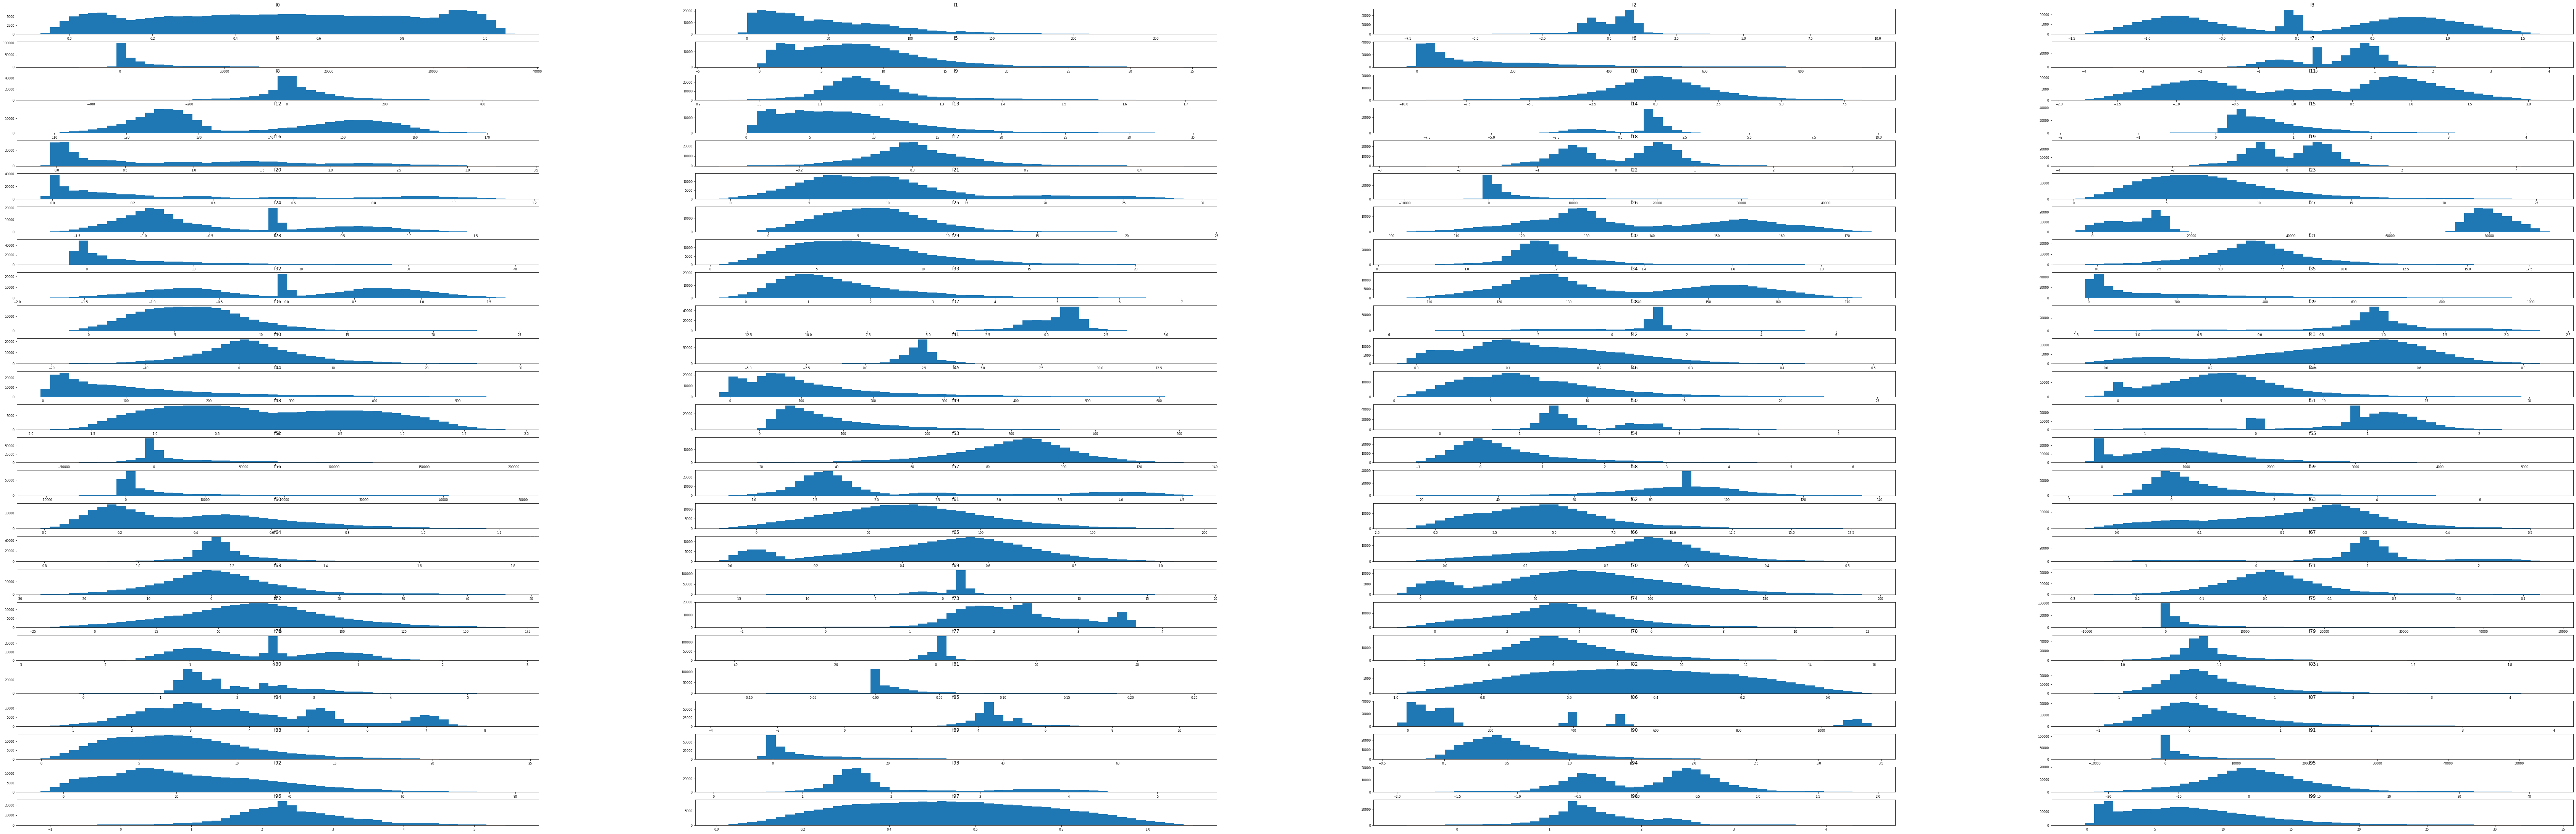

In [8]:
# Distributions of all features (many contain right skew)
feature_histograms = train_data[features].hist(figsize = (120, 160), bins=50, grid = False, xlabelsize=8, ylabelsize=8, layout = (101,4))

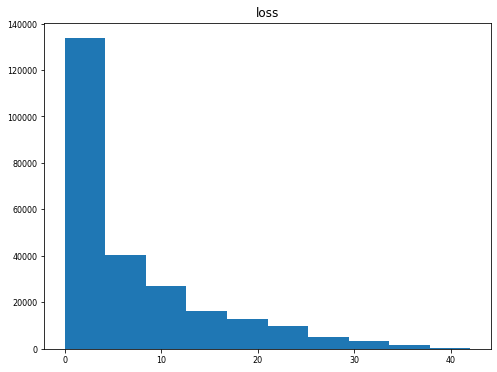

In [9]:
# Distribution of loss
loss_histogram = train_data[label].hist(figsize=(8,6), bins=10, grid=False, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

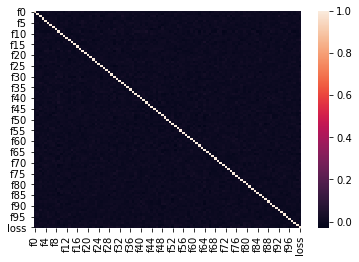

In [10]:
# No correlation between features
correlations = train_data.corr()
sns.heatmap(data=correlations)

## Data cleaning

In [11]:
X = train_data[features].values
y = train_data[label].values
X_test = test_data.values

In [12]:
# Scale feature data to be roughly the same range
# Only fit to train data to avoid data leakage
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

X_test

array([[ 0.97911337, -0.85805273, -1.01821102, ..., -0.03536929,
        -0.29390205,  0.13083379],
       [-1.04217744,  1.87801891, -0.46023133, ..., -1.27521872,
        -1.10322507,  0.66315896],
       [ 1.32666752, -0.76370543, -0.12444231, ...,  1.74020829,
         1.17586987,  0.17799391],
       ...,
       [-0.30500446,  2.13747398, -0.35169455, ..., -1.10000265,
         1.15543059,  0.75957575],
       [ 1.665202  , -0.81087908,  0.1966005 , ..., -0.36910158,
         0.11796273,  4.09306459],
       [-0.85048772, -0.0561007 ,  0.17963631, ..., -0.66162265,
        -0.02416845, -0.41649485]])

In [13]:
from sklearn.preprocessing import PowerTransformer

# Use yeo johnson to deal with skewed data (also deals with negative values)
# Only fit to train data to avoid data leakage
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(X)
X = pt.transform(X)
X_test = pt.transform(X_test)

X

array([[-1.6317675 ,  0.16767552,  0.4925626 , ...,  1.63715846,
         0.97911417,  0.38357395],
       [ 0.89967142,  1.28998401, -0.43672904, ..., -0.43996378,
         1.06197877, -1.64905282],
       [-0.6217876 , -0.99674662, -0.41258253, ...,  0.89369727,
         0.18053824,  0.62277652],
       ...,
       [-1.48033275,  0.037654  ,  0.26707514, ...,  1.25047825,
        -0.98745414, -1.85568502],
       [ 1.54543961, -1.27123166, -0.85633455, ...,  0.69136903,
        -1.06916271, -0.11603343],
       [-0.85568356, -0.00896006,  0.46490109, ..., -0.37953125,
        -1.12064554,  2.07094021]])

In [14]:
unskewed_train_data = pd.DataFrame(data=X, columns=features)
unskewed_train_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-1.631768,0.167676,0.492563,-1.736921,-0.976198,1.132860,-1.108075,1.278253,-0.163022,-1.298948,...,-0.541476,-0.949359,0.271548,-0.875020,1.100604,-0.066931,-0.672154,1.637158,0.979114,0.383574
1,0.899671,1.289984,-0.436729,-0.726107,0.827793,-1.068840,-0.022192,0.606861,-0.129557,0.724291,...,-1.332983,-0.989591,-1.177445,-0.435496,-0.934201,-0.411632,-1.863691,-0.439964,1.061979,-1.649053
2,-0.621788,-0.996747,-0.412583,-0.542294,-0.507122,1.428820,-1.099747,-0.944569,0.178218,0.448512,...,-0.668169,-0.935389,0.834261,0.806594,0.449638,-0.103105,-0.226537,0.893697,0.180538,0.622777
3,-0.961713,-1.073092,-0.554888,1.145502,-1.042122,-0.910400,0.105422,1.467093,-0.641425,-1.294342,...,-0.666557,-0.934767,-1.878782,-0.804289,0.772555,-1.467997,0.233308,0.348148,-0.191558,0.317466
4,-0.231397,-0.959201,0.640859,-0.179462,-0.963377,0.625809,-0.678485,-0.671599,0.077515,-1.135053,...,-0.123465,-0.857941,-0.515395,-0.390099,-0.905897,-0.017868,-0.250422,1.235729,0.307559,-0.182343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,1.366111,-1.522595,0.415987,-0.132431,-0.990568,-1.693536,-0.997147,0.642153,0.088786,-0.819180,...,-1.395356,-0.182355,-0.288231,-0.950635,0.937019,0.349356,0.481530,1.792121,-0.870552,-1.563030
249996,-0.857830,-1.479678,-0.508839,1.646610,-1.015597,1.224325,0.226062,-1.551812,-1.445241,0.029378,...,-1.447559,-0.466259,-0.217933,-0.610821,-0.390743,0.421757,-0.480479,0.959562,-0.238446,-1.624653
249997,-1.480333,0.037654,0.267075,0.833486,-0.318748,0.903479,-1.329077,-0.939359,0.645082,0.129246,...,-0.879416,-0.945436,-0.899762,-0.593386,-0.706975,2.244225,-1.632244,1.250478,-0.987454,-1.855685
249998,1.545440,-1.271232,-0.856335,0.669720,0.159632,0.462244,-1.422696,0.310794,1.029581,1.822145,...,-0.273137,-1.015975,-0.040316,0.766980,1.241797,0.110271,1.639952,0.691369,-1.069163,-0.116033


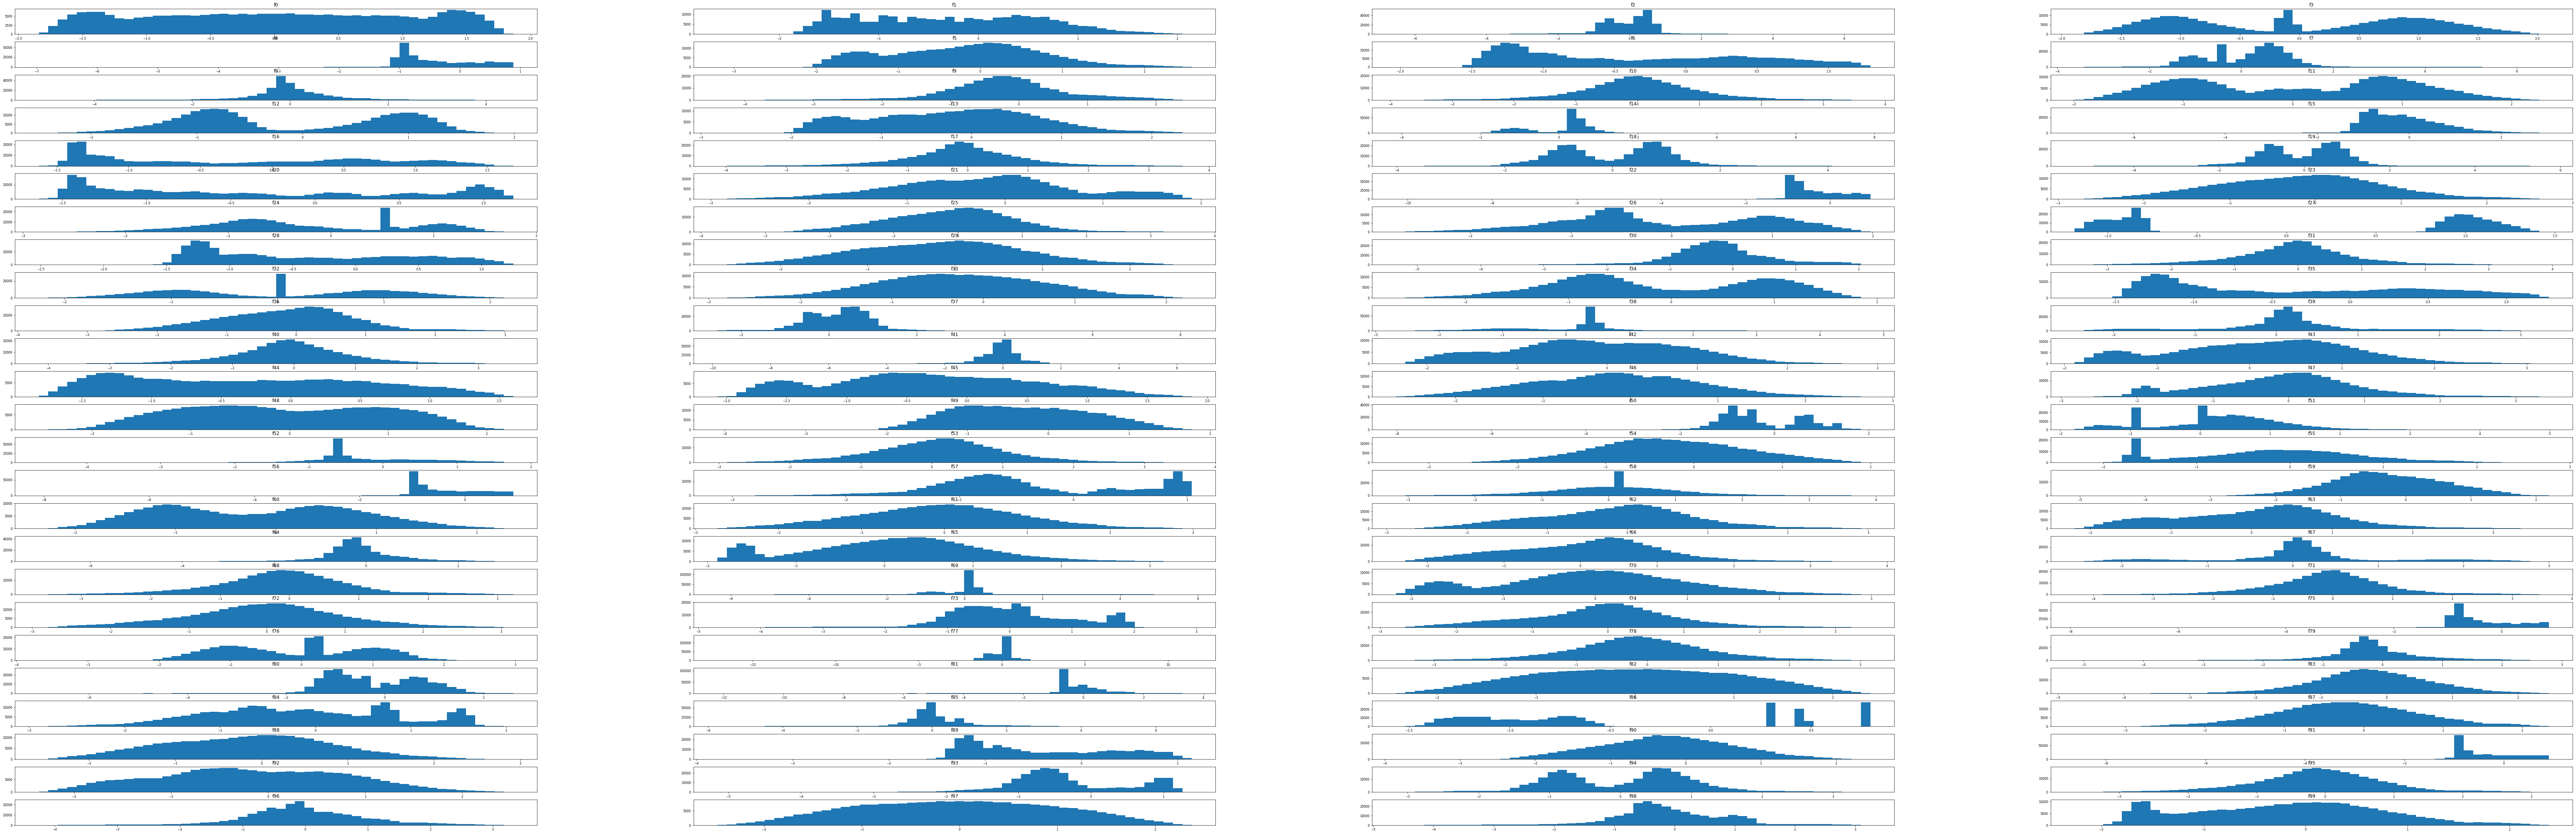

In [15]:
# Feature distributions after fixing skew (More but not all follow normal distribution)
unskewed_features = unskewed_train_data.hist(figsize = (120, 160), bins=50, grid = False, xlabelsize=8, ylabelsize=8, layout = (101,4))

## Hyperparameter Tuning + Modelling

In [16]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Define objective (what to optimize)
def objective(trial):
    # Split dataset for each trial (larger test size to prevent overfitting)
    X_train, X_val, y_train, y_val = train_test_split(X,y, stratify=y, test_size=0.4)
    
    # Specify ranges of hyperparameters to try 
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators',400,4000,400),
        'max_depth': trial.suggest_int('max_depth',6,10),
        'eta': trial.suggest_float('eta', 0.007,0.01),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2,0.9,0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0,2.0,0.1),
        #'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'gamma': trial.suggest_loguniform('gamma', 1e-4,1e4),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4,1e4),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4,1e4),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4,1e4),
    }
    
    # Apparently this set of parameters makes processing faster
    reg = XGBRegressor(
        objective = 'reg:tweedie',
        tree_method = 'gpu_hist',
        predictor = 'gpu_predictor',
        # Split job for 4 CPUs
        n_jobs=4,
        # Use set of params generated by param grid
        **param_grid
    )
    
    reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', verbose=False)
    
    return my_rmse(y_val, reg.predict(X_val))

In [17]:
# Study is Optuna's object to call functions on
# direction set to minimize as we want to lower rmse, sampler set to TPESampler for predicting one label
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(), study_name='XGBRegressor')
# Try different sets of hyperparameters set in objective and timeout at 1 hour (60s*60min) 
study.optimize(objective, timeout=60*60)

# trial object holds best params
trial = study.best_trial
print('Best root mean squared error: {}'.format(trial.value))
print('Best trial\'s parameters: ')
for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

[I 2022-03-24 06:54:51,522] A new study created in memory with name: XGBRegressor
[I 2022-03-24 06:55:14,812] Trial 0 finished with value: 7.86469344385807 and parameters: {'n_estimators': 2000, 'max_depth': 7, 'eta': 0.008201973872680172, 'subsample': 0.7, 'colsample_bylevel': 0.8, 'colsample_bytree': 0.4, 'tweedie_variance_power': 1.9, 'gamma': 0.0002405004737353268, 'min_child_weight': 0.009206994010312981, 'reg_alpha': 27.402913514516776, 'reg_lambda': 0.0008374153559929408}. Best is trial 0 with value: 7.86469344385807.
[I 2022-03-24 06:55:25,592] Trial 1 finished with value: 7.879196757458864 and parameters: {'n_estimators': 3600, 'max_depth': 9, 'eta': 0.008683714099823566, 'subsample': 0.6000000000000001, 'colsample_bylevel': 0.4, 'colsample_bytree': 0.2, 'tweedie_variance_power': 1.7000000000000002, 'gamma': 42.0424205056301, 'min_child_weight': 0.01262862109789158, 'reg_alpha': 0.002856395281274904, 'reg_lambda': 3.057154331147301}. Best is trial 0 with value: 7.8646934438580

Best root mean squared error: 7.838782855507567
Best trial's parameters: 
n_estimators: 3600
max_depth: 7
eta: 0.008273685118311952
subsample: 0.7
colsample_bylevel: 0.4
colsample_bytree: 0.4
tweedie_variance_power: 1.3
gamma: 10.541416949624221
min_child_weight: 509.01333889333114
reg_alpha: 19.197161235289023
reg_lambda: 2800.2455661626823


In [18]:
optuna.visualization.plot_optimization_history(study)

In [19]:
# See which hyperparameters are more important to tweak suggested ranges 
optuna.visualization.plot_param_importances(study)

## KFold Cross Validation on Best Model

In [20]:
from sklearn.model_selection import KFold

best_params = trial.params
best_params['objective'] = 'reg:tweedie'
best_params['tree_method'] = 'gpu_hist'
best_params['predictor'] = 'gpu_predictor'
best_params['n_jobs'] = 4

test_preds = None
rmse_list = []
fold_num = 1

# Use KFold CV to avoid overfitting
for train_index, val_index in KFold(n_splits=10, shuffle=True).split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    
    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', verbose=False)
    
    val_predictions = model.predict(X_val)
    rmse_val = my_rmse(y_val, val_predictions)
    print('Fold {fold_num} RMSE: {rmse:.4f}'.format(fold_num=fold_num, rmse=rmse_val))
    rmse_list.append(rmse_val)
    fold_num += 1
    
    # Use each fold's model to predict test values and add them to test_preds
    if test_preds is None:
        test_preds = model.predict(X_test)
    else:
        test_preds += model.predict(X_test)

# Get average of predictions from KFold CV for submission
test_preds /= fold_num
print('Average KFold rmse: {avg_rmse:.4f}'.format(avg_rmse = np.mean(np.array(rmse_list))))

Fold 1 RMSE: 7.8260
Fold 2 RMSE: 7.8885
Fold 3 RMSE: 7.8864
Fold 4 RMSE: 7.8397
Fold 5 RMSE: 7.8583
Fold 6 RMSE: 7.8189
Fold 7 RMSE: 7.7721
Fold 8 RMSE: 7.8680
Fold 9 RMSE: 7.8309
Fold 10 RMSE: 7.7912
Average KFold rmse: 7.8380


## Submission

In [21]:
submission_df = pd.DataFrame(data=test_preds, columns=['loss'])
submission_df.index = test_data.index
submission_df

,loss
id,
250000,7.117330
250001,4.325682
250002,7.702137
250003,6.715572
250004,6.616822
...,...
399995,6.732872
399996,6.802449
399997,5.394725


In [22]:
submission_df.to_csv('TPS August Submission')